# Text Analytics Group Assignment #1

**MIS 284N - Section B**   
   
**Members:**   
Patricia Schutter (pls949)   
Sujay Chebbi (sc64344)   
Immanuel Ponminissery (ijp284)   
Vikram Seth (vs22826)   
Lai Jiang (lj9384)

## Forum Summary 

The Edmunds discussion forum from which we chose to scrape data in order to gain insights from social media conversations is titled ***High End Luxury Sedans***.  
   
While technically the forum exists within the Audi/Audi A8 category, it is used as a general purpose discussion page for users to express opinions on a multitude of luxury car brands and models.  There are 463 pages of forum posts, from which we fetched the 4,500 least recent messages. The range of years in which these messages were posted was 1994-2004.   
   
The attributes of each message that were scraped and output into a CSV file included **Date, UserID, and Message.**   
   
The forum can be found at this [URL](https://forums.edmunds.com/discussion/1232/audi/a8/high-end-luxury-cars).

## Scraping

The following code only executes properly in the *Google Collab* environment.

In [ ]:
!pip install selenium
!apt-get -q update # to update ubuntu to correctly run APT install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_prefs = {}
chrome_options.experimental_options["prefs"] = chrome_prefs
prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options=chrome_options)
driver.set_page_load_timeout(600)
driver.get('https://forums.edmunds.com/discussion/1232/audi/a8/high-end-luxury-cars')
data = pd.DataFrame(columns=['date', 'userid', 'message'])

ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
comment_ids = []

#for pages in range(1,5):
for i in ids:
    comment_ids.append(i.get_attribute('id'))

for j in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[3]/div/div[1]')[0]
      comment = user_message.text
                                    
      #Adding date, userid and comment for each user in a dataframe    
      data.loc[len(data)] = [date,userid,comment]
        
del i,j

In [ ]:
#While Loop used to go through pages of forum

page_number = 1
while data.shape[0]<4500:
  page_number = page_number+1
  print(page_number)
  new_address = 'https://forums.edmunds.com/discussion/1232/audi/a8/high-end-luxury-cars/p'+str(page_number)
  #driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver = webdriver.Chrome(options=chrome_options)
  driver.set_page_load_timeout(600)
  driver.get(new_address)
  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []
  for i in ids:
    comment_ids.append(i.get_attribute('id'))
  for j in comment_ids:
    #Extract dates from for each user on a page
    user_date = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
    date = user_date.get_attribute('title')

    #Extract user ids from each user on a page
    userid_element = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
    userid = userid_element.text

    #Extract Message for each user on a page
    user_message = driver.find_elements_by_xpath('//*[@id="' + j +'"]/div/div[3]/div/div[1]')[0]
    comment = user_message.text
                                   
    #Adding date, userid and comment for each user in a dataframe    
    data.loc[len(data)] = [date,userid,comment]

The above code, when executed, outputs a CSV file titled *HW1_Data_v2.csv* which we will now read in for further analysis.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import sys

raw_data = pd.read_csv('HW1_Data_v2.csv', index_col=[0])
raw_data.head()

,date,userid,message
0,"November 23, 1999 6:20AM",enigma23,"All great cars, so let the discussions begin!!!"
1,"November 27, 1999 5:29AM",merc1,I guess no one wants to talk anymore huh?\n\nM
2,"November 27, 1999 3:17PM",bmwboys,I was talking wiht a friend of mine about this...
3,"November 27, 1999 6:29PM",bernard1,"Currently we own a vehicle from Lexus, both of..."
4,"November 27, 1999 9:40PM",merc1,"What ""toys"" does the LS400 offer that are not ..."


Additionally, we read in a CSV file titled *Car models and brands* for a reference of model-brand combinations. 

In [2]:
cars = pd.read_csv('car models and brands.csv')
cars.columns = ["brand","model"]

## Task A

First, we remove all stopwords from the "Message" attribute of each post, transform any mention of a specific model into its manufacturing brand name, and removed all duplicate mentions of each brand, allowing us to calculate frequency counts of words in order to identify the *Top 10 Brands by Frequency.*   

We first define functions for **data pre-processing** as:

In [3]:
#Removing all Stopwords

stop_words = set(stopwords.words('english'))

#Create a new column of messages without stopwords
def rid_stopwords(sentence):
  sentence = str(sentence)
  sentence = sentence.lower()
  sentence_split = re.split('\s|,|\.',sentence)
  filtered = []
  for word in sentence_split:
    if word not in stop_words:
      filtered.append(word)
  sentence = ' '.join(filtered)
  return sentence


#Replacing Car Model Name with Brand Names
def convert_model_to_brand(sentence):
  temp = []
  sentence = str(sentence)
  sentence = sentence.lower()
  sentence = re.split('\s|,|\.',sentence)
  for i in sentence:
    if i in list(cars['model']):
      address = list(cars['model']).index(i)
      temp.append(list(cars['brand'])[address])
    else:
      temp.append(i)
  return ' '.join(temp)

#Removing multiple mentions of the same brand name within each message
def rid_mult_mentions(sentence):
  sentence = str(sentence)
  sentence_split = sentence.split()
  new_s = []
  for i in sentence_split:
    if i not in list(cars['brand']):
      new_s.append(i)
    else:
      if new_s.count(i) == 0:
        new_s.append(i)
  return ' '.join(new_s)

In [4]:
#Execute the pre-processing functions

raw_data['message_without_stopwords'] = raw_data['message'].map(rid_stopwords)

raw_data['message_with_only_model_names'] = raw_data['message_without_stopwords'].map(convert_model_to_brand)

raw_data['message_only_models_no_stopwords_unique_brand'] = raw_data['message_with_only_model_names'].map(rid_mult_mentions)

raw_data.head()

,date,userid,message,message_without_stopwords,message_with_only_model_names,message_only_models_no_stopwords_unique_brand
0,"November 23, 1999 6:20AM",enigma23,"All great cars, so let the discussions begin!!!",great cars let discussions begin!!!,great cars let discussions begin!!!,great cars let discussions begin!!!
1,"November 27, 1999 5:29AM",merc1,I guess no one wants to talk anymore huh?\n\nM,guess one wants talk anymore huh?,guess one wants talk anymore huh?,guess one wants talk anymore huh?
2,"November 27, 1999 3:17PM",bmwboys,I was talking wiht a friend of mine about this...,talking wiht friend mine line autos came conc...,talking wiht friend mine line autos came conc...,talking wiht friend mine line autos came concl...
3,"November 27, 1999 6:29PM",bernard1,"Currently we own a vehicle from Lexus, both of...",currently vehicle lexus german makes volvo o...,currently vehicle lexus german makes volvo o...,currently vehicle lexus german makes volvo off...
4,"November 27, 1999 9:40PM",merc1,"What ""toys"" does the LS400 offer that are not ...","""toys"" ls400 offer available s-class 7-series ...","""toys"" lexus offer available mercedes bmw mea...","""toys"" lexus offer available mercedes bmw mean..."


After doing the pre-processsing, we exported the adjusted data frame into a new CSV file. From that file we calcualted word frequencies spanning all messages, and found each word's value count.

In [5]:
raw_data.to_csv("hw_1_clean_comments.csv")
word_frequency = raw_data.message_only_models_no_stopwords_unique_brand.str.split(expand=True).stack().value_counts()
word_frequency.to_csv("hw_1_word_frequency.csv")

**The Top 10 Brands were identified through an index-match with the DataFrame "cars".**

In [6]:
mask = word_frequency.index.isin(cars['brand'].unique())
top_10_brands = word_frequency[mask]
top_10_brands = top_10_brands[:10]
top_10_brands = top_10_brands.to_frame().reset_index()
top_10_brands.columns=['Brand','Frequency']
top_10_brands

,Brand,Frequency
0,mercedes,1795
1,lexus,1675
2,bmw,1533
3,audi,653
4,lincoln,617
5,jaguar,509
6,toyota,468
7,infiniti,350
8,cadillac,261
9,acura,253


In [7]:
#Define a lift function
def lift(calcLiftList, listofcomments, frequencyList):
  results = []
  totalComments = 4500
  for i in calcLiftList:
    counter = 0
    word_list = i
    all_comments = list(listofcomments)
    
    for comment in all_comments:
      comment = str(comment)
      comment = comment.split()

      temp_1 = comment.count(word_list[0])
      temp_2 = comment.count(word_list[1])

      if (temp_1>=1) and (temp_2>=1):
        counter = counter+1
      else:
        counter = counter+0
  
    firstWord = i[0]
    secondWord = i[1]
    #listFrequency = list(stackedFrequencyList)
    listFrequency = list(frequencyList)
    firstWordIndex = listFrequency.index(firstWord)
    firstWordCountIndex = firstWordIndex+1
    firstWordCount = listFrequency[firstWordCountIndex]
    secondWordIndex = listFrequency.index(secondWord)
    secondWordCountIndex = secondWordIndex+1
    secondWordCount = listFrequency[secondWordCountIndex]
    lift = (totalComments*counter)/(firstWordCount*secondWordCount)
    results.append(i)
    results.append(lift)
  
  return results

In [8]:
#Changing the original frequency list to search through it for word counts
frequency_list = pd.read_csv('hw_1_word_frequency.csv')
frequency_list = frequency_list.rename(columns={'Unnamed: 0':'Word','0':'Count'})
frequency_list.set_index('Word')
stackedFrequencyList = frequency_list.stack()

In [9]:
brandXBrandLiftWordList = pd.read_csv('brand lift words.csv')
brandXBrandLiftWordList = list(brandXBrandLiftWordList['combo'])
splitbrandXBrandLiftWordList = [brandXBrandLiftWordList[i:i+2] for i in range(0, len(brandXBrandLiftWordList), 2)]

In [10]:
#Read in the Brand x Brand list in
clean_data = pd.read_csv("hw_1_clean_comments.csv")
lift(splitbrandXBrandLiftWordList,clean_data['message_only_models_no_stopwords_unique_brand'],stackedFrequencyList)

[['mercedes', 'mercedes'],
 2.5069637883008355,
 ['lexus', 'mercedes'],
 1.6209204673013762,
 ['bmw', 'mercedes'],
 1.4521747188591925,
 ['audi', 'mercedes'],
 1.478072065077828,
 ['lincoln', 'mercedes'],
 1.438355236723656,
 ['jaguar', 'mercedes'],
 1.3741510745303205,
 ['toyota', 'mercedes'],
 1.3820441397043068,
 ['infiniti', 'mercedes'],
 1.2892956625547154,
 ['cadillac', 'mercedes'],
 1.2582845067716837,
 ['acura', 'mercedes'],
 1.5854316447752321,
 ['lexus', 'lexus'],
 2.6865671641791047,
 ['bmw', 'lexus'],
 1.335397377106639,
 ['audi', 'lexus'],
 1.3247697195492674,
 ['lincoln', 'lexus'],
 1.785239120443165,
 ['jaguar', 'lexus'],
 1.2878632378383132,
 ['toyota', 'lexus'],
 1.6877152698048221,
 ['infiniti', 'lexus'],
 1.5658848614072494,
 ['cadillac', 'lexus'],
 1.3381369016984046,
 ['acura', 'lexus'],
 1.5822075393782078,
 ['bmw', 'bmw'],
 2.935420743639922,
 ['audi', 'bmw'],
 1.807104347539431,
 ['lincoln', 'bmw'],
 1.3083317739075826,
 ['jaguar', 'bmw'],
 1.6205367956047505,
 

Below is the **Similarity (Lift) Matrix** between brands.

In [11]:
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
sim_list = lift(splitbrandXBrandLiftWordList,clean_data['message_only_models_no_stopwords_unique_brand'],stackedFrequencyList)

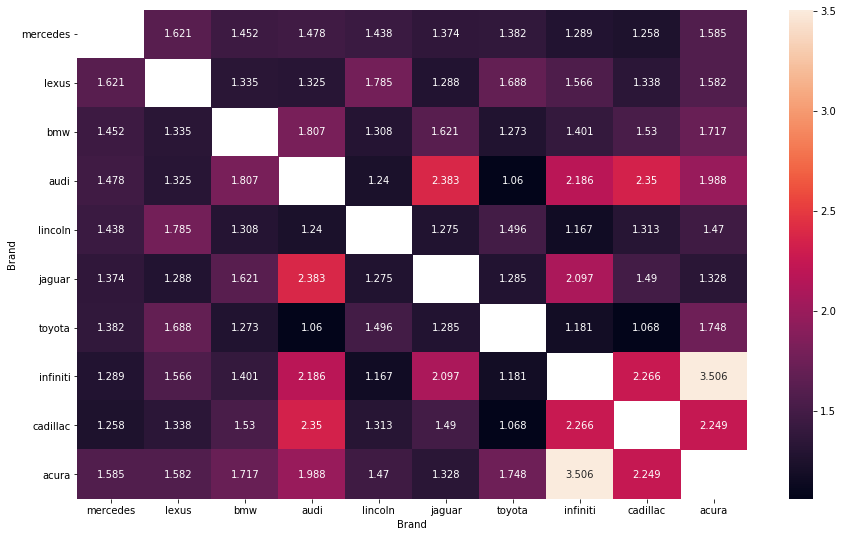

In [13]:
brand_list = []
scores_list = []

for i in range(0, len(sim_list)):
    if i%2==0:
        brand_list.append(sim_list[i])
    else:
        scores_list.append(sim_list[i])  
        
sim_pd = pd.DataFrame(index = top_10_brands['Brand'], columns= top_10_brands['Brand'])
combined = pd.DataFrame()
combined['brands'] = brand_list
combined['scores'] = scores_list
for val in range(0,len(combined['brands'])):
    if combined['brands'][val][0]==combined['brands'][val][1]:
        sim_pd.loc[combined['brands'][val][0],combined['brands'][val][1]] = np.nan
    else:
        sim_pd.loc[combined['brands'][val][0],combined['brands'][val][1]] = combined['scores'][val]
        sim_pd.loc[combined['brands'][val][1],combined['brands'][val][0]] = combined['scores'][val]
sim_pd.fillna(value=np.nan, inplace=True)  
fig,ax = plt.subplots(figsize = (15,9))
sns.heatmap(sim_pd, annot=True,fmt ='.4g')

Below is the **Dissimilarity Matrix** between brands.

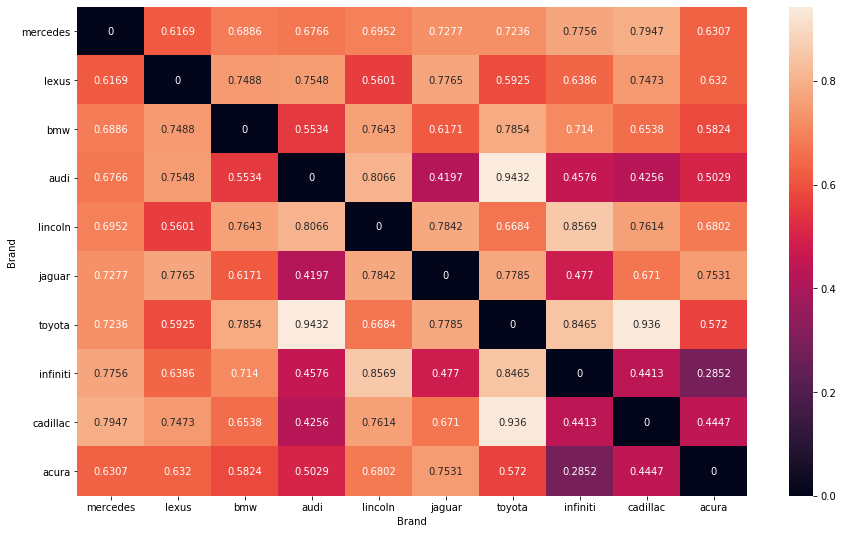

In [14]:
dis = sim_pd.apply(np.reciprocal).copy()
for num in range(0,len(dis.index.values)):
    dis.iloc[num,num]=0
fig,ax = plt.subplots(figsize = (15,9))
sns.heatmap(dis, annot=True, fmt = '.4g')

Below is the **MDS Map** of the brands.

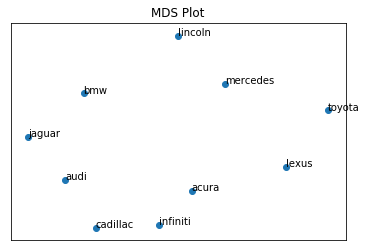

In [15]:
trial1 = manifold.MDS(n_components = 2,random_state=0, dissimilarity='precomputed')
coords = trial1.fit_transform(dis)
x = list()
y = list()
for i in range(0,len(coords)):
  x.append(coords[i][0])
  y.append(coords[i][1])
plt.scatter(x,y)
plt.xticks([])
plt.yticks([])
plt.title('MDS Plot')

for i in range(0,len(coords)):
  plt.annotate(list(sim_pd.index.values)[i],(x[i],y[i]))


## Task B

The two brands with the most highest lift values and lowest distance on the MDS plot are *Acura* and *Infiniti*. A useful insight to the brand managers of both brands would be that this similarity score indicates that they are each other's top competitors in their market. Both of their parent companies, Nissan and Honda respectively, are Japanese mass-producers of luxury sedans. The public shows similar brand perception and popularity between the two makes.

This insight is relevant, as the MDS plot shows no data points in the center. This means that there is not one brand that is uniquely more similar to all other brands in the market. From a brand manager's perspective, an MDS plot with roughly equidistant points and lacks centrality indicates that consumers don't have one specific brand that they view as similar to most. The brand managers of Acura and Infiniti can use this information to position their brand strategy around each other, as opposed to one brand that is consistently a competitor to all makes in the entry-level luxury sedan market. 

## Task C

In [16]:
#Read in the Brand X Attribute list to run lift
attributeXBrandLiftList = pd.read_csv('attribute x brand list.csv')
attributeXBrandLiftList = list(attributeXBrandLiftList['combo'])
splitAttributeXBrandList = [attributeXBrandLiftList[i:i+2] for i in range(0, len(attributeXBrandLiftList), 2)]
attribute_lift =lift(splitAttributeXBrandList,clean_data['message_only_models_no_stopwords_unique_brand'],stackedFrequencyList)

In [17]:
brand_attribute_list = []
scores_2_list = []

for i in range(0, len(attribute_lift)):
    if i%2==0:
        brand_attribute_list.append(attribute_lift[i])
    else:
        scores_2_list.append(attribute_lift[i]) 

In [18]:
brand_att_pd = pd.DataFrame()

In [19]:
combined = pd.DataFrame()
combined['brands'] = brand_attribute_list
combined['scores'] = scores_2_list

In [20]:
for val in range(0,len(combined['brands'])):
        brand_att_pd.loc[combined['brands'][val][1],combined['brands'][val][0]] = combined['scores'][val]

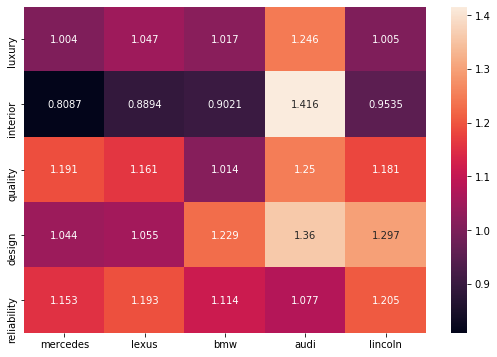

In [21]:
fig,ax = plt.subplots(figsize = (9,6))
sns.heatmap(brand_att_pd.loc[['luxury','interior','quality','design','reliability'],['mercedes','lexus','bmw','audi','lincoln']],annot = True, fmt ='.4g')

The five most frequently mentioned attributes of cars in the discussion are **luxury, interior, quality, design, and reliability,** in that order. The above matrix shows the association values between each of the five most common attributes have and the top five most popular brands. 

## Task D

### Mercedes

***Product Manager***   
The product manager of Mercedes should use the above table to understand which of the most important attributes to consumers have the lowest assocation with their brand. Mercedes is ranked the lowest for design among the top five brands, indicating the need for a break from previous model design patterns. With that, they should focus on the luxurious and interior aspects of their next model, as Mercedes has the lowest associaions in the market for both of these attributes. Some actionable advice would be to design new models with increased interior space and finer material, as well as design the cabin for more amenities to increase customer perception of "luxury". 

***Marketing Manager***  
Mercedes' marketing manager should orient their strategy toward playing into the attributes that customers tend to associate most with Mercedes, thereby playing into the brand's strenghts. Mercedes has the second highest association of these brands for quality, and they have the third highest association for reliability. In advertising, the marketing manager should emphasize these characteristics through positive messaging related to the materials and durability of their products.  

### Lexus

***Product Manager***   
A product manager at Lexus needs to focus redesigning around both overall design as well as interior. For both attributes, Lexus has the second lowest level of association, placing directly behind BMW. If the product manager were able to further improve upon these attributes by following trends for both interior and overall design similar to Audi or Lincoln, Lexus’ customer perception would be substantially improved, as these are the lowest association attributes for the brand itself.

***Marketing Manager***  
The highest attribute associations between Lexus are in reliability and quality, where the brand is the second and third most highly associated, respectively, trailing Lincoln in both cases. Lexus should lean heavily on these characteristics in advertising to potentially absorb a portion of Lincoln’s luxurious sedan markets share, since the differences in these attributes' lift values are realtively small. This strategy would be efficient, as the remaining attributes have substantially higher differences in lift, suggesting that marketing on reliability and quality may yield more realistic success. 

### BMW

***Product Manager***    
We would recommend that a BMW product manager focus on the quality and reliability of future products, as BMW's brand ranks lowest and second lowest, respectively, in these attribute association levels. This makes sense, as quality and reliability go hand-in-hand in customer perception of capabilitly and durability. This could be done by procuring higher quality engine parts, paints, and wheels, while also and ensuring opitmal customer service during service repaires to build higher levels of positive associations related to BMW and reliability.

***Marketing Manager***  
A BMW marketing manager to focus on the more positive aspects of BMW cars, which include luxury, interior, and design. These three attributes define BMW's brand perception in the first place as the interior of many BMW cars are what attract customers. Advertisements should display the luxury of BMW's interior design.

### Lincoln

***Product Manager***   
We would recommend that a Lincoln product manager focus on the luxurious aspects of future Lincoln cars. People do not tend to associate Lincoln with luxury as they might for the other 4 brands. This might include using higher quality material for upholstery and for the dashboard, or adding interior amenities. Relative to other brands, Lincoln has high association values for all other attributes, which means that a focus on luxurious design could establish consistent high values for all attributes. 

***Marketing Manager***    
A Lincoln marketing manager should focus on the premier aspects of their cars, which include their reliability and design. Lincoln advertisements should display how reliable their vehicles, perhaps with metrics such as engine life, owner satisfaction, and fuel efficiency. Their advertisements should also display the exceptional exterior design. Since Lincoln is relatively close to Audi in the MDS plot as compared to the other top five brands, this strategy would also be efficient as Lincoln could potentially gain higher a association value for design than Audi and solidify an even higher lift for reliability than Audi, giving Lincoln potential to gain market share. 

### Audi

***Product Manager***     
An Audi product manager should look at this analysis and wonder why their reliability ranks the worst among the 4 other popular car brands, while ranking the best in luxury, interior, quality and design. Audi clearly takes care of the aesthetics of their cars and build quality, but when it comes to reliability it seems like they are lacking quite a bit. Examples of improving reliability could be importing or building very high quality engine parts and combustion engines and quality transmission fluid.

***Marketing Manager***   
We would recommend an Audi marketing manager to focus on any aspect of luxury, interior, quality, and design. Advertisements should include high quality displays of Audi's exterior and interior. To increase customer perception of reliability, considering that the only attribute for which Audi doesn't have the highst lift value is reliability, Audi advertisements should include any product improvements or features that express sentiment of durability or useability. 

## Task E

We measured the "aspirational" quality of a car by creating a list of phrases that had hints of aspiration or desire. This list can be seen below.

In [22]:
task_e_words = pd.read_csv('aspirational_words.csv')
task_e_words.tail(10) 

,quality,terms
57,aspiration,demanding for
58,aspiration,hoping for
59,aspiration,fancying to
60,aspiration,sight for
61,aspiration,thirsting for
62,aspiration,urging to
63,aspiration,might buy
64,aspiration,might want
65,aspiration,would like
66,aspiration,test drive


We then added the word "aspiration" to the end of comments in which aspirational bigrams were present and removed multiple instances of the word from each comment. We did a lift analysis by these five car brands with respect to the number of times "aspiration" appeared. 

In [23]:
def replace_aspirational_terms(sentence):
  sentence = str(sentence)
  sentence = sentence.lower()
  sentence = re.split('\s|,|\.',sentence)
  sentence = ' '.join(sentence)

  for i in range(0,len(list(task_e_words['terms']))):
    if list(task_e_words['terms'])[i] in sentence:
      sentence = sentence+' aspiration'
    else:
      pass
  
  if 'aspiration' in sentence:
    sentence = sentence.split()
    count_aspiration = sentence.count('aspiration')
    sentence = ' '.join(sentence[0:-1*count_aspiration+1])
  
  return sentence

In [24]:
raw_aspiration_data = pd.read_csv('HW1_Data_v2.csv',index_col=[0])
raw_aspiration_data['message_with_aspiration'] = raw_aspiration_data['message'].map(replace_aspirational_terms)
raw_aspiration_data['with_aspiration_and_brand'] = raw_aspiration_data['message_with_aspiration'].map(convert_model_to_brand)
raw_aspiration_data['with_aspiration_and_brand_mentioned_once'] = raw_aspiration_data['with_aspiration_and_brand'].map(rid_mult_mentions)
raw_aspiration_data.head()

,date,userid,message,message_with_aspiration,with_aspiration_and_brand,with_aspiration_and_brand_mentioned_once
0,"November 23, 1999 6:20AM",enigma23,"All great cars, so let the discussions begin!!!",all great cars so let the discussions begin!!!,all great cars so let the discussions begin!!!,all great cars so let the discussions begin!!!
1,"November 27, 1999 5:29AM",merc1,I guess no one wants to talk anymore huh?\n\nM,i guess no one wants to talk anymore huh? m,i guess no one wants to talk anymore huh? m,i guess no one wants to talk anymore huh? m
2,"November 27, 1999 3:17PM",bmwboys,I was talking wiht a friend of mine about this...,i was talking wiht a friend of mine about this...,i was talking wiht a friend of mine about this...,i was talking wiht a friend of mine about this...
3,"November 27, 1999 6:29PM",bernard1,"Currently we own a vehicle from Lexus, both of...",currently we own a vehicle from lexus both of...,currently we own a vehicle from lexus both of...,currently we own a vehicle from lexus both of ...
4,"November 27, 1999 9:40PM",merc1,"What ""toys"" does the LS400 offer that are not ...","what ""toys"" does the ls400 offer that are not ...","what ""toys"" does the lexus offer that are not ...","what ""toys"" does the lexus offer that are not ..."


In [25]:
word_frequency_aspiration = raw_aspiration_data.with_aspiration_and_brand_mentioned_once.str.split(expand=True).stack().value_counts()
word_frequency_aspiration.to_csv("hw_1_word_frequency_with_aspiration.csv")

We then created a Frequency list including "aspiration". Stopwords were not removed here, as the aspiration bigram synonyms themselves included terms such as "to".

In [26]:
frequency_list_aspiration = pd.read_csv('hw_1_word_frequency_with_aspiration.csv')
frequency_list_aspiration[:5]

,Unnamed: 0,0
0,the,26202
1,a,10721
2,and,10015
3,to,9439
4,i,9233


In [27]:
frequency_list_aspiration = pd.read_csv('hw_1_word_frequency_with_aspiration.csv')
frequency_list_aspiration = frequency_list_aspiration.rename(columns={'Unnamed: 0':'Word','0':'Count'})
frequency_list_aspiration
frequency_list_aspiration.set_index('Word')

#Get Aspiration X Brand Association List
stackedFrequencyListAspiration = frequency_list_aspiration.stack()
brandXAspirationWordList = pd.read_csv('brand x aspiration list.csv')
brandXAspirationWordList = list(brandXAspirationWordList['combo'])
splitbrandXAspirationWordList = [brandXAspirationWordList[i:i+2] for i in range(0, len(brandXAspirationWordList), 2)]

We then plotted the lift associations between each brand and "aspiration" to gauge which one had the highest co-mention frequency of its brand name and aspirational bigrams.

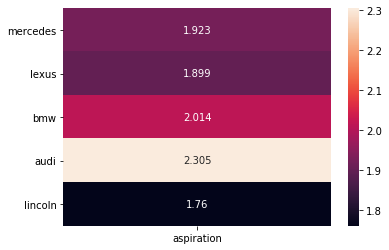

In [28]:
aspirationXBrand = lift(splitbrandXAspirationWordList,raw_aspiration_data['with_aspiration_and_brand_mentioned_once'],stackedFrequencyListAspiration)
aspirationXBrandDF_columns = []
for i in range(0,len(aspirationXBrand),2):
    aspirationXBrandDF_columns.append(str(aspirationXBrand[i][0]))
aspirationXBrandDF = pd.DataFrame(columns = aspirationXBrandDF_columns, index = ['aspiration'])
for lift_val in range(1,len(aspirationXBrand)+1,2):
    aspirationXBrandDF.loc['aspiration',aspirationXBrand[lift_val-1][0]] = float(aspirationXBrand[lift_val])
sns.heatmap(aspirationXBrandDF.T.astype(float) ,annot = True, fmt ='.4g')

As the above plot displays, Audi has the highest lift value with the term, and therefore the highest aspirational value. This means that within forums of consumers with interest in entry-level luxury sedans, posts that inclue Audi's name most frequently include aspirational phrases that may be positively correlated to consumer interest or increasing demand, relative to the other four most popular brands. It leads by a substantial margin, with BMW coming in second. While Lincoln was relatively high in comparison to other brands in multiple attributes, they are lowest in aspirational value.   
   
Considering that within the list of the top five most popular brands Audi conceptually perceived to be most similar to BMW, having a high aspiration value could indicate that Audi has the potential to gain some of BMW's currently held market share. If consumers have indicated excitement towards the potential to purchase Audi products in the future, BMW should be concerned with differentiating themselves from Audi to avoid this potential increase in competition.

## Audi Consideration

In [29]:
word_frequency.loc['audi']/len(raw_data)
print('No. of messages that contain Audi/Total no. of messages is {:.4f}'.format(word_frequency.loc['audi']/len(raw_data)))

No. of messages that contain Audi/Total no. of messages is 0.1451


Considering the relatively low proportion of messages within the forum that include the word "audi", any concerns regarding bias towards Audi from the forum's subheading are mitigated.